In [1]:
import pandas as pd
df_train = pd.read_csv('../Final Dataset/@final_training_ndvi_prediction.csv')


In [2]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [3]:
nan_cols = df_train.columns[df_train.isna().any()].tolist()

print("Các cột có NaN trong df_val:")
for col in nan_cols:
    print(f"{col}: {df_train[col].isna().sum()} NaN")


Các cột có NaN trong df_val:
ndvi_mean_lag1: 133 NaN
ndvi_mean_lag2: 266 NaN
ndvi_mean_lag3: 399 NaN
ndvi_mean_roll3_mean: 133 NaN
ndvi_mean_roll3_std: 266 NaN
ndvi_mean_roll3_min: 133 NaN
ndvi_mean_roll3_max: 133 NaN
ndvi_mean_exp_mean: 133 NaN
ndvi_mean_exp_std: 266 NaN


In [4]:
import numpy as np
import pandas as pd

from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

# 1. Cột NDVI cần impute
ndvi_cols = [
    "ndvi_mean_lag1",
    "ndvi_mean_lag2",
    "ndvi_mean_lag3",
    "ndvi_mean_roll3_mean",
    "ndvi_mean_roll3_std",
    "ndvi_mean_roll3_min",
    "ndvi_mean_roll3_max",
    "ndvi_mean_exp_mean",
    "ndvi_mean_exp_std",
]

target_col = "next_16day_ndvi_mean"

# 2. Các cột KHÔNG dùng cho imputation
drop_cols = ["NAME_1", "NAME_2", "GID_1", target_col]

feature_for_impute = [
    c for c in df_train.columns
    if c not in drop_cols and c != "GID_2"
]

cols_for_impute = ndvi_cols + [
    c for c in feature_for_impute if c not in ndvi_cols
]

df_train_imp = df_train.copy()
imputers_by_gid = {}  # lưu imputer cho từng huyện

for gid, group in df_train_imp.groupby("GID_2"):
    g = group.copy()

    data = g[cols_for_impute].replace([np.inf, -np.inf], np.nan)

    # Nếu tất cả NDVI trong huyện đều NaN cho 1 cột nào đó → dùng global mean
    for col in ndvi_cols:
        if data[col].isna().all():
            global_mean = df_train[col].mean()
            data[col] = data[col].fillna(global_mean)

    imputer = IterativeImputer(
        estimator=RandomForestRegressor(
            n_estimators=200,
            max_depth=10,
            random_state=42,
            n_jobs=-1
        ),
        max_iter=15,
        random_state=42
    )

    imputed_array = imputer.fit_transform(data)
    imputed_df = pd.DataFrame(imputed_array, columns=cols_for_impute, index=g.index)

    # Gán lại NDVI đã impute vào train
    df_train_imp.loc[g.index, ndvi_cols] = imputed_df[ndvi_cols]

    # Lưu imputer để lát nữa dùng cho val/test
    imputers_by_gid[gid] = imputer

print("NaN trong NDVI (train) sau impute:")
print(df_train_imp[ndvi_cols].isna().sum())


NaN trong NDVI (train) sau impute:
ndvi_mean_lag1          0
ndvi_mean_lag2          0
ndvi_mean_lag3          0
ndvi_mean_roll3_mean    0
ndvi_mean_roll3_std     0
ndvi_mean_roll3_min     0
ndvi_mean_roll3_max     0
ndvi_mean_exp_mean      0
ndvi_mean_exp_std       0
dtype: int64


In [5]:
def apply_group_imputer(df_in, imputers_by_gid, cols_for_impute, ndvi_cols):
    """
    df_in:   df_val hoặc df_test (chưa impute)
    imputers_by_gid: dict {gid: IterativeImputer đã fit trên train của gid đó}
    cols_for_impute: list các cột được đưa vào imputer (ndvi_cols + feature predictor)
    ndvi_cols:       các cột NDVI cần điền khuyết
    """
    df_out = df_in.copy()
    
    for gid, group in df_out.groupby("GID_2"):
        g = group.copy()
        
        # lấy đúng các cột cần đưa qua imputer
        data = g[cols_for_impute].replace([np.inf, -np.inf], np.nan)

        if gid in imputers_by_gid:
            imputer = imputers_by_gid[gid]
            imputed_array = imputer.transform(data)
            imputed_df = pd.DataFrame(
                imputed_array,
                columns=cols_for_impute,
                index=g.index
            )
            # chỉ ghi đè lại các cột NDVI
            df_out.loc[g.index, ndvi_cols] = imputed_df[ndvi_cols]
        else:
            # huyện xuất hiện ở val/test nhưng không có trong train
            # fallback: fill mean theo group hiện tại
            data_filled = data.copy()
            for col in ndvi_cols:
                if data_filled[col].isna().all():
                    # nếu cả group toàn NaN → dùng global mean từ df_in
                    global_mean = df_in[col].mean()
                    data_filled[col] = data_filled[col].fillna(global_mean)
                else:
                    data_filled[col] = data_filled[col].fillna(data_filled[col].mean())
            
            df_out.loc[g.index, ndvi_cols] = data_filled[ndvi_cols]

    return df_out


In [30]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers, models

def build_ann_with_gid_embedding(n_features, n_regions):
    l2_reg = 0.01
    dropout_rate = 0.2

    # ----- INPUT 1: weather + NDVI features -----
    feat_input = layers.Input(shape=(n_features,), name="features")

    x = layers.Dense(250, activation='relu',
                     kernel_regularizer=regularizers.l2(l2_reg))(feat_input)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(200, activation='relu',
                     kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(150, activation='relu',
                     kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.Dropout(dropout_rate)(x)

    # ----- INPUT 2: GID_2 embedding -----
    region_input = layers.Input(shape=(1,), dtype="int32", name="gid2")
    region_emb = layers.Embedding(input_dim=n_regions,
                                  output_dim=16)(region_input)
    region_emb = layers.Flatten()(region_emb)
    region_emb = layers.Dense(16, activation='relu')(region_emb)

    # ----- MERGE -----
    merged = layers.Concatenate()([x, region_emb])

    y = layers.Dense(100, activation='relu')(merged)
    y = layers.Dropout(dropout_rate)(y)
    y = layers.Dense(50, activation='relu')(y)
    y = layers.Dropout(dropout_rate)(y)
    y = layers.Dense(25, activation='relu')(y)
    y = layers.Dense(10, activation='relu')(y)

    output = layers.Dense(1, activation='linear')(y)

    model = models.Model(inputs=[feat_input, region_input], outputs=output)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(3e-5),
        loss='mse',
        metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")]
    )

    return model


In [7]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow as tf

# ===== 0. Load dữ liệu =====
df_train = df_train_imp.copy()
df_val_raw   = pd.read_csv("../Final Dataset/@final_validation_ndvi_prediction.csv")
df_test_raw  = pd.read_csv("../Final Dataset/@final_testing_ndvi_prediction.csv")

# ===== 0.1. Áp dụng group imputer lên VAL & TEST =====
df_val  = apply_group_imputer(df_val_raw,  imputers_by_gid, cols_for_impute, ndvi_cols)
df_test = apply_group_imputer(df_test_raw, imputers_by_gid, cols_for_impute, ndvi_cols)

print("NaN NDVI (val) :", df_val[ndvi_cols].isna().sum())
print("NaN NDVI (test):", df_test[ndvi_cols].isna().sum())

# ===== 1. Chuẩn bị cột =====
drop_cols = ['NAME_1', 'GID_1', 'NAME_2', 'year']  # nếu có start_date/end_date thì thêm luôn vào đây
target_col = 'next_16day_ndvi_mean'

feature_cols = [
    c for c in df_train.columns
    if c not in drop_cols + [target_col, 'GID_2']
]

# ===== 2. Mapping GID_2 nhất quán giữa train/val/test =====
gid_categories = df_train['GID_2'].astype('category').cat.categories

df_train['GID_2_code'] = pd.Categorical(df_train['GID_2'],
                                        categories=gid_categories).codes
df_val['GID_2_code']   = pd.Categorical(df_val['GID_2'],
                                        categories=gid_categories).codes
df_test['GID_2_code']  = pd.Categorical(df_test['GID_2'],
                                        categories=gid_categories).codes

# ===== 3. Tách X_num, X_gid, y =====
# Train
X_num_train = df_train[feature_cols].values.astype("float32")
X_gid_train = df_train['GID_2_code'].values.astype("int32")
y_train     = df_train[target_col].values.astype("float32")

# Val
X_num_val = df_val[feature_cols].values.astype("float32")
X_gid_val = df_val['GID_2_code'].values.astype("int32")
y_val     = df_val[target_col].values.astype("float32")

# Test
X_num_test = df_test[feature_cols].values.astype("float32")
X_gid_test = df_test['GID_2_code'].values.astype("int32")
y_test     = df_test[target_col].values.astype("float32")

# ===== 4. Chuẩn hoá numeric features (fit trên train, apply cho val/test) =====
scaler = StandardScaler()
X_num_train_scaled = scaler.fit_transform(X_num_train)
X_num_val_scaled   = scaler.transform(X_num_val)
X_num_test_scaled  = scaler.transform(X_num_test)



NaN NDVI (val) : ndvi_mean_lag1          0
ndvi_mean_lag2          0
ndvi_mean_lag3          0
ndvi_mean_roll3_mean    0
ndvi_mean_roll3_std     0
ndvi_mean_roll3_min     0
ndvi_mean_roll3_max     0
ndvi_mean_exp_mean      0
ndvi_mean_exp_std       0
dtype: int64
NaN NDVI (test): ndvi_mean_lag1          0
ndvi_mean_lag2          0
ndvi_mean_lag3          0
ndvi_mean_roll3_mean    0
ndvi_mean_roll3_std     0
ndvi_mean_roll3_min     0
ndvi_mean_roll3_max     0
ndvi_mean_exp_mean      0
ndvi_mean_exp_std       0
dtype: int64


In [ ]:
# ===== 5. Build model với embedding cho huyện =====
n_regions = len(gid_categories)
model = build_ann_with_gid_embedding(
    n_features=X_num_train_scaled.shape[1],
    n_regions=n_regions,
)

# ===== 6. Early stopping =====
callback_es = tf.keras.callbacks.EarlyStopping(
    monitor='val_rmse',
    patience=20,
    restore_best_weights=True
)

# ===== 7. Train =====
history = model.fit(
    {"features": X_num_train_scaled, "gid2": X_gid_train},
    y_train,
    validation_data=(
        {"features": X_num_val_scaled, "gid2": X_gid_val},
        y_val
    ),
    epochs=200,
    batch_size=64,
    callbacks=[callback_es],
    verbose=1
)

# ===== 7b. Đánh giá trên validation (MSE, RMSE) =====
val_loss, val_rmse = model.evaluate(
    {"features": X_num_val_scaled, "gid2": X_gid_val},
    y_val,
    verbose=0
)
print("Val loss (MSE):", val_loss)
print("Val RMSE:", val_rmse)

# ===== 7c. Tính R², MSE, MAE trên validation =====
def r2_score_np(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1.0 - ss_res / ss_tot if ss_tot != 0 else np.nan

y_pred_val = model.predict(
    {"features": X_num_val_scaled, "gid2": X_gid_val},
    verbose=1
).flatten()

r2_val = r2_score_np(y_val, y_pred_val)
mse_val = mean_squared_error(y_val, y_pred_val)
mae_val = mean_absolute_error(y_val, y_pred_val)

print("Val R²:", r2_val)
print("Val MSE:", mse_val)
print("Val MAE:", mae_val)

# ===== 8. Đánh giá trên test (MSE, RMSE) =====
test_loss, test_rmse = model.evaluate(
    {"features": X_num_test_scaled, "gid2": X_gid_test},
    y_test,
    verbose=0
)
print("Test loss (MSE):", test_loss)
print("Test RMSE:", test_rmse)

# ===== 9. Tính R², MSE, MAE trên test =====
y_pred_test = model.predict(
    {"features": X_num_test_scaled, "gid2": X_gid_test},
    verbose=0
).flatten()

r2_test = r2_score_np(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)

print("Test R²:", r2_test)
print("Test MSE:", mse_test)
print("Test MAE:", mae_test)



Epoch 1/200
342/342 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.7489 - rmse: 0.3570 - val_loss: 4.0460 - val_rmse: 0.2126
Epoch 2/200
342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.8637 - rmse: 0.2357 - val_loss: 3.2931 - val_rmse: 0.1890
Epoch 3/200
342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.1303 - rmse: 0.2018 - val_loss: 2.6414 - val_rmse: 0.1658
Epoch 4/200
342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.5020 - rmse: 0.1768 - val_loss: 2.0898 - val_rmse: 0.1520
Epoch 5/200
342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.9719 - rmse: 0.1596 - val_loss: 1.6283 - val_rmse: 0.1388
Epoch 6/200
342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.5310 - rmse: 0.1468 - val_loss: 1.2492 - val_rmse: 0.1323
Epoch 7/200
342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.1695 - rmse: 0.1379 - val_loss: 0.9413 - val_rmse: 0.1262
Epoch 8/200
342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8773 - rmse: 0.1306 - val_loss: 0.6956 - val_rmse: 0.1214
Epoch 9/200
342/342 ━━━━━━━━━━━━

In [9]:
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ features            │ (None, 54)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 250)       │     13,750 │ features[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 250)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 200)       │     50,200 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gid2 (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 200)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 16)     │      2,128 │ gid2[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 150)       │     30,150 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 16)        │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 150)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 16)        │        272 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 166)       │          0 │ dropout_2[0][0],  │
│ (Concatenate)       │                   │            │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 100)       │     16,700 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 100)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 50)        │      5,050 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 50)        │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 25)        │      1,275 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 10)        │        260 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 1)         │         11 │ dense_7[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 359,390 (1.37 MB)

 Trainable params: 119,796 (467.95 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 239,594 (935.92 KB)

In [34]:
import matplotlib.pyplot as plt


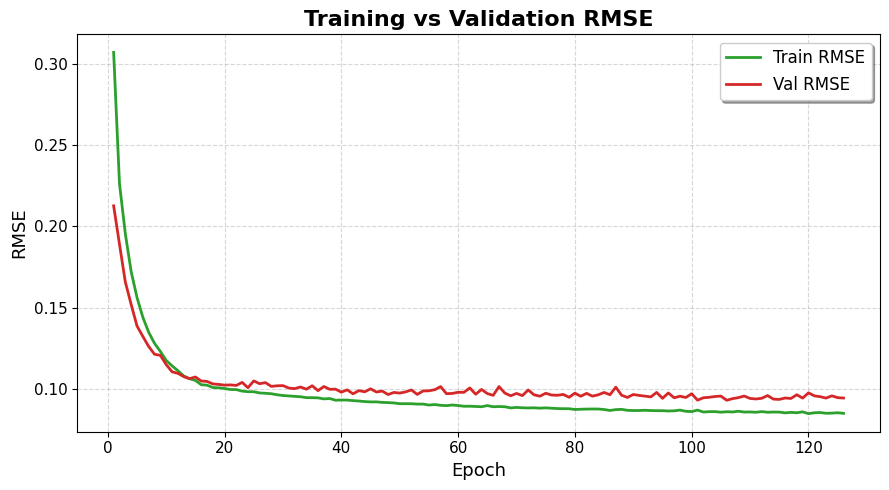

In [35]:
train_rmse = history.history["rmse"]
val_rmse = history.history["val_rmse"]
epochs = np.arange(1, len(train_rmse) + 1)

plt.figure(figsize=(9,5))
plt.plot(epochs, train_rmse, label="Train RMSE", color="#2ca02c", linewidth=2)
plt.plot(epochs, val_rmse, label="Val RMSE", color="#d62728", linewidth=2)

plt.title("Training vs Validation RMSE", fontsize=16, fontweight='bold')
plt.xlabel("Epoch", fontsize=13)
plt.ylabel("RMSE", fontsize=13)

plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(fontsize=12, frameon=True, shadow=True)

plt.tight_layout()
plt.show()


In [40]:
region_input = layers.Input(shape=(1,), dtype="int32", name="gid2")
X_gid_test = X_gid_test.reshape(-1, 1)   # thành (N, 1)


In [44]:
import numpy as np

X_num_test = df_test[feature_cols].values.astype("float32")   # (N, 54)
X_gid_test = df_test['GID_2_code'].values.astype("int32")     # (N,)

# BẮT BUỘC: reshape GID về (N, 1)
X_gid_test = X_gid_test.reshape(-1, 1)

print("X_num_test:", type(X_num_test), X_num_test.shape, X_num_test.dtype)
print("X_gid_test:", type(X_gid_test), X_gid_test.shape, X_gid_test.dtype)


X_num_test: <class 'numpy.ndarray'> (2645, 54) float32
X_gid_test: <class 'numpy.ndarray'> (2645, 1) int32


In [56]:
# Ép thành Tensor cho chắc
x_feat = tf.convert_to_tensor(X_num_test_scaled, dtype=tf.float32)
x_gid  = tf.convert_to_tensor(X_gid_test, dtype=tf.int32)

# Gọi model ở chế độ inference (training=False)
y_pred_tf = model([x_feat, x_gid],training=False)

# Lấy numpy ra
y_pred = y_pred_tf.numpy().reshape(-1)


In [57]:
print("model.inputs:", model.inputs)


model.inputs: [<KerasTensor shape=(None, 54), dtype=float32, sparse=False, name=features>, <KerasTensor shape=(None, 1), dtype=int32, sparse=False, name=gid2>]


In [58]:
y_pred_tf


<tf.Tensor: shape=(2645, 1), dtype=float32, numpy=
array([[0.74530613],
       [0.7551582 ],
       [0.6970199 ],
       ...,
       [0.5914154 ],
       [0.62320524],
       [0.6960851 ]], dtype=float32)>

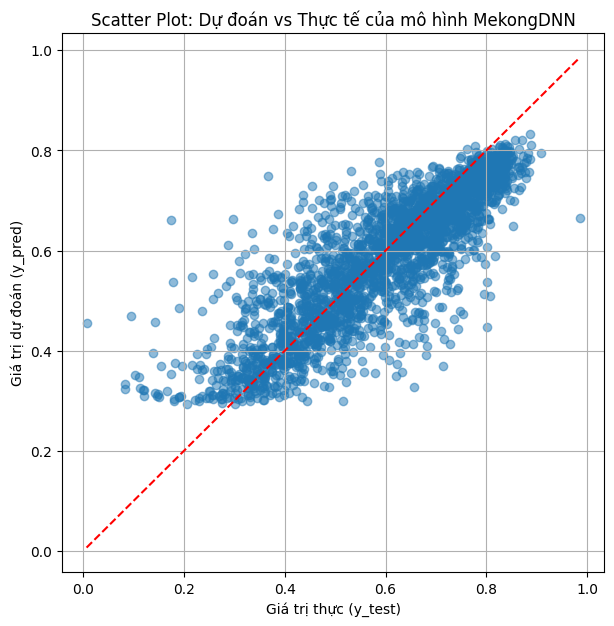

In [61]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 7))
plt.scatter(y_test, y_pred, alpha=0.5)

min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--')

plt.xlabel("Giá trị thực (y_test)")
plt.ylabel("Giá trị dự đoán (y_pred)")
plt.title("Scatter Plot: Dự đoán vs Thực tế của mô hình MekongDNN")
plt.grid(True)
plt.show()


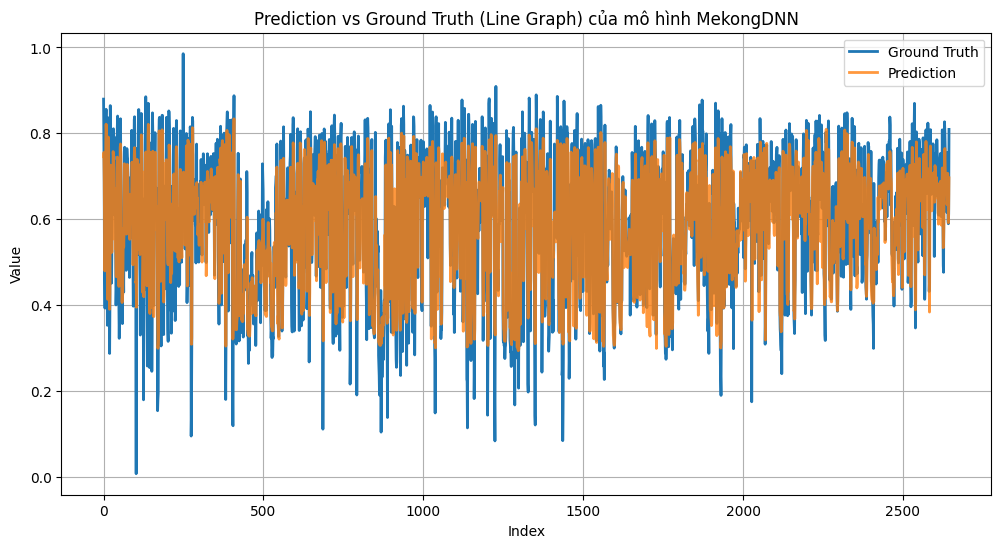

In [62]:
plt.figure(figsize=(12, 6))

plt.plot(y_test, label="Ground Truth", linewidth=2)
plt.plot(y_pred, label="Prediction", linewidth=2, alpha=0.8)

plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Prediction vs Ground Truth (Line Graph) của mô hình MekongDNN")
plt.legend()
plt.grid(True)
plt.show()


In [63]:
model.save("ndvi_ann_model.h5")
model.save("ndvi_ann_model.keras")  # Keras format mới


In [64]:
model_1 = tf.keras.models.load_model("Model file/ndvi_ann_model.keras")


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 21 variables whereas the saved optimizer has 40 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
y_pred_1 = model_1([x_feat, x_gid],training=False)
y_pred_1



<tf.Tensor: shape=(2645, 1), dtype=float32, numpy=
array([[0.74530613],
       [0.7551582 ],
       [0.6970199 ],
       ...,
       [0.5914154 ],
       [0.62320524],
       [0.6960851 ]], dtype=float32)>

: 